In [2]:
import os
import copy
import time
import math
import random
import itertools
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from IPython.display import clear_output

In [3]:
def df_to_arr(df):
    
    vals = []
    for _, row in df.iterrows():
        vals.extend(row.tolist())
    return np.array([x for x in vals if str(x) != 'nan'])

In [4]:
def labels_to_int(labels, classes):
    return np.array([0 if label == classes[1] else 1 for label in labels])

# SVM Training Methods

<a href="https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf">Guide to SVM Training</a>

In [5]:
def get_subjects(path):
    
    '''
    Gets a list of subject IDs and the file suffix, given a path to the data files. 
    
    Note: subject ID must be only 2 characters for this to work, and all data files
    must have same suffix.
    
    Parameters
    ----------
    path: str
        directory to the data files
        
    Returns
    -------
    list
        a list of subject IDs
    str
        the suffix to the filenames
    '''
    
    files = os.listdir(path)
    subjects = [f[:2] for f in files]
    suffix = files[0][2:]
        
    subjects.sort()
    
    return subjects, suffix

In [6]:
def scramble_labels(y_data, classes):
    
    '''
    Randomly selects half of the labels in the data to switch to the other class.
    
    Parameters
    ----------
    y_data: array-like
        label data to scramble
    classes: list
        the two different classes of labels
    '''
    
    y_data_copy = y_data.copy()
    for index in np.nditer(np.random.choice(len(y_data), size=len(y_data)//2, replace=False)):
        
        if y_data[index] == classes[0]:
            y_data[index] = classes[1]
        else:
            y_data[index] = classes[0]
    
    # Makes sure labels are scrambled properly
    num_diff = sum(i != j for i, j in zip(y_data, y_data_copy))  
    if num_diff != len(y_data)//2:
        raise ValueError
    

In [ ]:
def get_min_max_block_length(path, subjects, suffix, roi, conds):
    
    '''
    Gets the minimum and maximum lengths of the blocks in the data.
    
    Parameters
    ----------
    path: str
        directory to data files
    subject: str
        ID of subject to load data for
    suffix: str
        ending suffix of the data filename
    roi: int
        0 for V1 data, 1 for MT data
    conds: list
        list of integers specifying the conditional datasets to extract
        
    Returns
    -------
    int
        minimum block length
    int
        maxmimum block length
    '''
    
    min_bl, max_bl = math.inf, 0
    for subject in subjects:
        
        path_to_file = path + subject + suffix
        mat = scipy.io.loadmat(path_to_file)['roi_scanData'][0][roi]

        for scan in range(len(mat[0])):
            for cond in conds:
                for block in range(len(mat[0][scan][0][cond][0])):
        
                    block_data = []
                    for tr in range(len(mat[0][scan][0][cond][0][block][0])):
                        block_data.extend(mat[0][scan][0][cond][0][block][0][tr][0][0][0].tolist())
                    
                    min_bl = min(min_bl, len(block_data))
                    max_bl = max(max_bl, len(block_data))
                    
    print(f"Min block length: {min_bl}")
    print(f"Max block length: {max_bl}")

    return min_bl, max_bl

In [ ]:
def extract_subject_data(path, subject, suffix, roi, conds, block_length, rank_first, shuffle):
    
    '''
    Extracts individual subject data from the .mat files.
    
    Parameters
    ----------
    path: str
        directory to data files
    subject: str
        ID of subject to load data for
    suffix: str
        ending suffix of the data filename
    roi: int
        0 for V1 data, 1 for MT data
    conds: list
        list of integers specifying the conditional datasets to extract
        (0 for trained_cp, 1 for trained_ip, 2 for untrained_cp, 3 for untrained_ip)
    block_length: int
        the number of voxels to standardize every block in the dataset to
    rank_first: boolean
        whether to use first block in subject to order the rest of the blocks for that subject
    shuffle: boolean
        whether to shuffle order of voxels entirely
        
    Returns
    -------
    List of voxel data (x_data) separated by individual blocks and the corresponding labels (y_data)
    '''
    
    x_data = []
    y_data = []
    
    path_to_file = path + subject + suffix
    mat = scipy.io.loadmat(path_to_file)['roi_scanData'][0][roi]
    
    ranked_indices = None
    
    for scan in range(len(mat[0])):
            
        for cond in conds:
            
            blocks = [x for x in range(len(mat[0][scan][0][cond][0]))]
            if shuffle and rank_first:
                random.shuffle(blocks)
            for block in blocks:
                block_data = []
                for tr in range(len(mat[0][scan][0][cond][0][block][0])):
                    # Extract all voxel data from individual TRs
                    block_data.extend(mat[0][scan][0][cond][0][block][0][tr][0][0][0].tolist())
                    
                if rank_first:
                    # Rank-orders a given subject's block based on the order of its first encountered block
                    if ranked_indices is None:
                        ranked_indices = [i for i in (np.array(block_data)).argsort()[-block_length:]]
                        ranked_indices = np.flip(ranked_indices)
                    block_data = [block_data[i] if i < len(block_data) else 0.0 for i in ranked_indices]
                else:
                    # Filters for most active voxels in each block
                    block_data.sort()
                    block_data = block_data[-block_length:]
                
                x_data.append(block_data)
                y_data.append(mat[0][scan][1][cond][0])
    
    data = {'x': x_data, 'y': y_data}
    return data

In [8]:
def generate_dataset(subjects, path, suffix, roi, conds, block_length, rank_first, shuffle):
    
    '''
    Generates entire dataset from subject list, partitioned by subject.
    
    Parameters
    ----------
    subjects: list
        a list of subject IDs to extract data from
    path: str
        the path to the data files
    suffix: str
        ending suffix of the data filename
    roi: int
        0 for V1 data, 1 for MT data
    conds: list
        list of integers specifying the conditional datasets to extract
        (0 for trained_cp, 1 for trained_ip, 2 for untrained_cp, 3 for untrained_ip)    
    block_length: int
        the number of voxels to standardize every block in the dataset to
    rank_first: boolean
        whether to use first block in subject to order the rest of the blocks for that subject
    shuffle: boolean
        whether to shuffle order of voxels entirely
    
    Returns
    -------
    dict
        voxel data with subject key
    dict
        label data with subject key
    '''
    
    x_data = []
    
    x_data_indices = []
    y_data_by_subject = dict()
    
    for subject in subjects:
        
        subject_data = extract_subject_data(path, subject, suffix, roi, conds, block_length, rank_first, shuffle)
        x_data_indices.append(len(x_data))
        y_data_by_subject[subject] = subject_data['y']
        
        x_data.extend(subject_data['x'])
    
    # MinMaxScaler scales each feature to values between 0 and 1 among all x data
    scaler = MinMaxScaler(feature_range=(0, 1))
    x_standardized = scaler.fit_transform(x_data)
    
    # Sorts block data into respective subject
    x_data_by_subject = dict()
    for i in range(len(subjects)):
        subject = subjects[i]
        start_index = x_data_indices[i]
        end_index = x_data_indices[i+1] if i+1 < len(x_data_indices) else len(x_data)
        
        x_data_by_subject[subject] = x_standardized[start_index:end_index]
    
    return x_data_by_subject, y_data_by_subject

In [67]:
def get_optimal_run(x_train, y_train, x_test, y_test, kernels, gamma_range, C_range):
    
    '''
    Gets best hyperparameters (kernel, C, and gamma values) that optimize SVM's predictions for given
    x and y test dataset.
    
    Parameters
    ----------
    x_train: array-like
        dataset of block data used to train classifier
    y_train: array-like
        dataset of label data used to train classifier
    x_test: array-like
        testing dataset of block data used to optimize hyperparameters on
    y_test: array-like
        testing dataset of label data used to optimize hyperparameters on
    kernels: list
        kernels to test (recommended options are 'linear', 'rbf', and 'sigmoid')
    gamma_range: dict
        dict that specifies the range of values of gamma to test; should include start, stop to range,
        num of values, and the exponential base
    C_range: dict
        dict that specifies the range of values of C to test; should include start, stop to range,
        num of values, and the exponential base
        
    Returns
    -------
    dict
        best combination of parameters found from grid search
    float
        best accuracy obtained from testing
    '''
    
    gamma_vals = np.logspace(gamma_range['start'], gamma_range['stop'], gamma_range['num'], base=gamma_range['base'])
    C_vals = np.logspace(C_range['start'], C_range['stop'], C_range['num'], base=C_range['base'])

    param_grid = ParameterGrid({'kernel': kernels, 'gamma': gamma_vals, 'C': C_vals})
    
    best_acc = 0
    best_params = None
    
    # Tests each parameter combination to find best one for given testing data
    for params in list(param_grid):
        
        svclassifier = SVC(kernel=params['kernel'], gamma=params['gamma'], C=params['C'], max_iter=-1)
        svclassifier.fit(x_train, y_train)
        
        curr_acc = svclassifier.score(x_test, y_test)
        
        if curr_acc > best_acc:
            best_acc = curr_acc
            best_params = params
            
    return best_params, best_acc

In [10]:
def split_dataset(x_data, y_data, inner_subjects, outer_subject, scramble, classes):
    
    '''
    Splits voxel and label data into appropriate testing and training data for nested
    cross-validation with SVM.
    
    Parameters
    ----------
    x_data: dict
        voxel data with subject key
    y_data: dict
        label data with subject key
    inner_subjects: list
        list of subject IDs of the inner test subjects
    outer_subject: str
        the ID of the outer test subject
    scramble: boolean, optional
        whether or not to scramble the labels when training, 
        default is False
    classes: list, required if scramble is True
        label classes for the data (should be length of 2)
    
    Returns
    -------
    list
        blocks of voxel data for training use
    list
        training labels for respective blocks
    list
        blocks of voxel data from inner test subject(s) for testing use
    list 
        labels for inner test subject(s)
    list
        blocks of voxel data from outer test subject for testing use
    list
        labels for outer test subject    
    '''
    
    x_train = []
    y_train = []
    
    x_test_inner = []
    y_test_inner = []
    
    x_test_outer = []
    y_test_outer = []
    
    for subject in x_data.keys():
        if subject == outer_subject:
            x_test_outer.extend(x_data[subject])
            y_test_outer.extend(y_data[subject])
        elif subject in inner_subjects:
            x_test_inner.extend(x_data[subject])
            y_test_inner.extend(y_data[subject])
        else:
            x_train.extend(x_data[subject])
            if scramble:
                y_scrambled = y_data[subject].copy()
                scramble_labels(y_scrambled, classes)
                y_train.extend(y_scrambled)
            else:
                y_train.extend(y_data[subject])
            
    return x_train, y_train, x_test_inner, y_test_inner, x_test_outer, y_test_outer

In [11]:
def train(data_params, grid_params, num_inner=1, scramble=False, classes=None, rank_first=True, shuffle=False):
    
    '''
    Trains and tests the classifier for accuracy using SVMs.
    
    Parameters
    ----------
    data_params: dict
        path: str
            the path to the data files
        roi: int
            0 for V1 data, 1 for MT data
        conds: list
            list of integers specifying the conditional datasets to extract
            (0 for trained_cp, 1 for trained_ip, 2 for untrained_cp, 3 for untrained_ip)   
    grid_params: dict
        kernels: list
            kernels to test (recommended options are 'linear', 'rbf', and 'sigmoid')
        gamma: dict
            dict that specifies the range of values of gamma to test; should include start, stop to range,
            num of values, and the exponential base
        C: dict
            dict that specifies the range of values of C to test; should include start, stop to range,
            num of values, and the exponential base
    num_inner: int
        number of inner subjects to test classifier on,
        default is 1
    scramble: boolean, optional
        whether or not to scramble the labels when training, 
        default is False
    classes: list, required if scramble is True
        label classes for the data (should be length of 2)
    rank_first: boolean
        whether to use first block in subject to order the rest of the blocks for that subject,
        default is True
    shuffle: boolean
        whether to randomize which block to use in rank-ordering, 
        default is False
        
    Returns
    -------
    DataFrame
        data of inner subject combination testing accuracy
    DataFrame
        data of outer subject testing accuracy
    '''
    
    if scramble and classes is None:
        print('You must pass a list of label classes if scrambling the label data!')
        raise ValueError
    
    subjects, suffix = get_subjects(data_params['path'])
    
    bmin, bmax = get_min_max_block_length(data_params['path'], subjects, suffix, data_params['roi'], data_params['conds'])
    block_length = bmin
    x_data, y_data = generate_dataset(subjects, data_params['path'], suffix, data_params['roi'], data_params['conds'], block_length, rank_first, shuffle)
    
    # Sets up DataFrames used to track inner and outer subject test accuracies
    cols = []
    for combo in itertools.combinations(range(len(subjects)), num_inner):
        col = ''
        for subject in combo:
            col += '/' + subjects[subject]
        cols.append(col[1:])
    inner_acc_report = pd.DataFrame(index=subjects, columns=cols)
    outer_acc_report = pd.DataFrame(index=subjects, columns=cols)
    
    for outer_subject in subjects:
        
        print(f"Currently on outer subject #{subjects.index(outer_subject)+1}.")

        start_time = time.time()
        
        inner_subjects = [s for s in subjects if s != outer_subject]
        for inner_test_subjects in itertools.combinations((inner_subjects), num_inner):
            
            inner_test_subjects = list(inner_test_subjects)
            
            col = ''
            for subject in inner_test_subjects:
                col += '/' + subject
            col = col[1:]
            print(f"Currently on combination of {col}.")    
            
            x_train, y_train, x_test_inner, y_test_inner, x_test_outer, y_test_outer = split_dataset(x_data, y_data, inner_test_subjects, outer_subject, scramble, classes)
            
            # Gets optimal params for training dataset from grid search
            opt_params, inner_acc = get_optimal_run(x_train, y_train, x_test_inner, y_test_inner, grid_params['kernels'], grid_params['gamma'], grid_params['C']) 

            # Trains model using optimal params for this set
            svclassifier = SVC(kernel=opt_params['kernel'], gamma=opt_params['gamma'], C=opt_params['C'], max_iter=-1)
            svclassifier.fit(x_train, y_train)
            
            outer_acc = svclassifier.score(x_test_outer, y_test_outer)
            
            # Logs inner and outer subject accuracy data in DataFrame
            inner_acc_report.at[outer_subject, col] = inner_acc
            outer_acc_report.at[outer_subject, col] = outer_acc

        clear_output()
        
        # Prints how long it took for last outer subject test
        end_time = time.time()
        exec_time = end_time - start_time
        minutes = exec_time // 60
        seconds = exec_time % 60
        print(f"Last turn took {minutes} minutes and {seconds} seconds.")
    
    clear_output()
    return inner_acc_report, outer_acc_report

# Training Classifier

## Verifying Rank-Order Robustness

True accuracy of rank-order appears to lie around 0.533. <br>
For reference, using first block in rank-order produced accuracy of 0.540.

In [334]:
# Shuffle which block is used to rank other blocks within subject

path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3

gamma_range = {'start': -13, 'stop': 1, 'num': 16, 'base': 2.0}
C_range = {'start': -3, 'stop': 11, 'num': 16, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

data_params = {'path': path, 'roi': roi, 'conds': conds}
grid_params = {'gamma': gamma_range, 'C': C_range, 'kernels': kernels}

inner_samples = []
outer_samples = []
for runs in range(10):
    print(f'On run {runs+1}.')
    
    inner_accs, outer_accs = train(data_params, grid_params, rank_first=True, shuffle=True)
    inner_samples.append(df_to_arr(inner_accs))
    outer_samples.append(df_to_arr(outer_accs))
    
inner_accs.to_csv('output/rank/inner_accs16_bshuff.csv')
outer_accs.to_csv('output/rank/outer_accs16_bshuff.csv')

## Tests with Different Number of Inner Subjects Per Fold

In [32]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3

gamma_range = {'start': -13, 'stop': 1, 'num': 32, 'base': 2.0}
C_range = {'start': -3, 'stop': 11, 'num': 32, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

data_params = {'path': path, 'roi': roi, 'conds': conds}
grid_params = {'gamma': gamma_range, 'C': C_range, 'kernels': kernels}

inner_accs, outer_accs = train(data_params, grid_params, num_inner=2, rank_first=True)

inner_accs.to_csv('output/rank/inner_accs32_2inner.csv')
outer_accs.to_csv('output/rank/outer_accs32_2inner.csv')

## Miscellaneous Tests

In [59]:
# Original GS64 Run

path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3

gamma_range = {'start': -13, 'stop': 1, 'num': 64, 'base': 2.0}
C_range = {'start': -3, 'stop': 11, 'num': 64, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

data_params = {'path': path, 'roi': roi, 'conds': conds}
grid_params = {'gamma': gamma_range, 'C': C_range, 'kernels': kernels}

inner_accs, outer_accs = train(data_params, grid_params, rank_first=False)

inner_accs.to_csv('output/inner_accs64.csv', sep='\t')
outer_accs.to_csv('output/outer_accs64.csv', sep='\t')

In [14]:
# Expanded GS32 Run

path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3

gamma_range = {'start': -15, 'stop': 5, 'num': 32, 'base': 2.0}
C_range = {'start': -5, 'stop': 15, 'num': 32, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

data_params = {'path': path, 'roi': roi, 'conds': conds}
grid_params = {'gamma': gamma_range, 'C': C_range, 'kernels': kernels}

inner_accs, outer_accs = train(data_params, grid_params, rank_first=False)

inner_accs.to_csv('output/inner_accs32_more.csv', sep='\t')
outer_accs.to_csv('output/outer_accs32_more.csv', sep='\t')

In [343]:
# Danny's grid search

path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3

gamma_range = {'start': -11, 'stop': 3, 'num': 15, 'base': 2.0}
C_range = {'start': -3, 'stop': 11, 'num': 15, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

data_params = {'path': path, 'roi': roi, 'conds': conds}
grid_params = {'gamma': gamma_range, 'C': C_range, 'kernels': kernels}

inner_accs, outer_accs = train(data_params, grid_params, rank_first=True)
print(f"Inner accuracy: {np.mean(df_to_arr(inner_accs))}")
print(f"Outer accuracy: {np.mean(df_to_arr(outer_accs))}")

Inner accuracy: 0.7789797008547008
Outer accuracy: 0.5387286324786326


In [342]:
# GS19 (Based on SVM Guide)

path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3

gamma_range = {'start': -15, 'stop': 3, 'num': 38, 'base': 2.0}
C_range = {'start': -3, 'stop': 15, 'num': 38, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

data_params = {'path': path, 'roi': roi, 'conds': conds}
grid_params = {'gamma': gamma_range, 'C': C_range, 'kernels': kernels}

inner_accs, outer_accs = train(data_params, grid_params, rank_first=True)
print(f"Inner accuracy: {np.mean(df_to_arr(inner_accs))}")
print(f"Outer accuracy: {np.mean(df_to_arr(outer_accs))}")

Inner accuracy: 0.7845886752136751
Outer accuracy: 0.5556891025641025


In [15]:
# GS19 (Based on SVM Guide)

path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [0, 2]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3

gamma_range = {'start': -15, 'stop': 3, 'num': 19, 'base': 2.0}
C_range = {'start': -3, 'stop': 15, 'num': 19, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

data_params = {'path': path, 'roi': roi, 'conds': conds}
grid_params = {'gamma': gamma_range, 'C': C_range, 'kernels': kernels}

inner_accs, outer_accs = train(data_params, grid_params, rank_first=True)
print(f"Inner accuracy: {np.mean(df_to_arr(inner_accs))}")
print(f"Outer accuracy: {np.mean(df_to_arr(outer_accs))}")

Inner accuracy: 0.7288995726495727
Outer accuracy: 0.5430021367521368


# Permutation Runs

In [336]:
def permutation(data_params, grid_params, inner_dist, outer_dist, classes, runs=30, history=True):
    
    '''
    Performs a specified number of runs where data labels are scrambled.
    
    Parameters
    ----------
    data_params: dict
        contains specifications for data processing (see train method for documentation)
    grid_params: dict
        contains values for grid search (see train method for documentation)
    inner_dist: list
        holds accuracy values for individual inner subject tests
    outer_dist: list
        holds accuracy values for individual outer subject tests
    classes: list
        label classes for the data (should be length of 2)
    runs: int
        number of runs to perform, default is 30
    history: boolean
        whether to track accuracy over runs and output permutation accuracy plot, 
        default is True
    '''
    
    if history:
        outer_sample_means = []
        for i in range(len(outer_dist)//156):
            outer_sample_means.append(np.mean(outer_dist[i*156:(i+1)*156]))
        
        x = [i for i in range(1, len(outer_sample_means)+1)]
        if len(outer_sample_means) > 0:
            y = [outer_sample_means[0]]
            for i in range(2, len(outer_sample_means)+1):
                y.append(np.mean(outer_sample_means[:i]))
        else:
            y = []
        
    for n in range(runs):
        print(f'On run #{n+1} of {runs}.')
        inner_accs, outer_accs = train(data_params, grid_params, scramble=True, classes=classes, rank_first=True)
        
        inner_dist.extend(df_to_arr(inner_accs).tolist())
        outer_dist.extend(df_to_arr(outer_accs).tolist())
        
        outer_sample_means.append(np.mean(df_to_arr(outer_accs)))
        
        if history:
            y.append(np.mean(outer_sample_means))
            x.append(len(y))

            plt.plot(x, y)
            plt.xlabel('Run')
            plt.ylabel('Overall Mean Accuracy')
            plt.title('Overall Outer Subject Accuracy')
            plt.savefig(f"output/permutations/perm_hist.png")
        

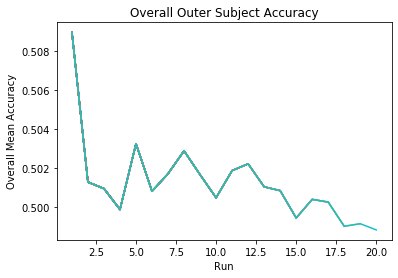

In [266]:
gamma_range = {'start': -13, 'stop': 1, 'num': 15, 'base': 2.0}
C_range = {'start': -3, 'stop': 11, 'num': 15, 'base': 2.0}

path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624

kernels = ['rbf', 'sigmoid']
classes = ['trained_ip', 'untrained_ip']

data_params = {'path': path, 'roi': roi, 'conds': conds}
grid_params = {'gamma': gamma_range, 'C': C_range, 'kernels': kernels}

inner_dist = []
outer_dist = []
permutation(data_params, grid_params, inner_dist, outer_dist, classes, runs=20)

np.save('output/permutations/outer_dist15.npy', outer_dist)
np.save('output/permutations/inner_dist15.npy', inner_dist)

# Using Deep Neural Network

DNN Guides:
<br><a href="https://www.dlology.com/blog/quick-notes-on-how-to-choose-optimizer-in-keras/">Optimizers</a>
<br><a href="https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-i-hyper-parameter-8129009f131b">DNN Layers</a>

In [134]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers

In [340]:
def trainNN(data_params, classes, epochs=20, layer_size=256, num_inner=1, scramble=False, rank_first=True, shuffle=False):
    
    '''
    Trains and tests the classifier for accuracy using NNs.
    
    Parameters
    ----------
    data_params: dict
        path: str
            the path to the data files
        roi: int
            0 for V1 data, 1 for MT data
        conds: list
            list of integers specifying the conditional datasets to extract
            (0 for trained_cp, 1 for trained_ip, 2 for untrained_cp, 3 for untrained_ip)  
    classes: list, required if scramble is True
        label classes for the data (should be length of 2)
    epochs: int
        number of iterations to train model on
    layer_size: int
        size of hidden layer
    num_inner: int
        number of inner subjects to test classifier on,
        default is 1
    scramble: boolean, optional
        whether or not to scramble the labels when training, 
        default is False
    rank_first: boolean
        whether to use first block in subject to order the rest of the blocks for that subject,
        default is True
    shuffle: boolean
        whether to randomize which block to use in rank-ordering, 
        default is False
        
    Returns
    -------
    DataFrame
        data of inner subject combination testing accuracy
    DataFrame
        data of outer subject testing accuracy
    '''
    
    if scramble and classes is None:
        print('You must pass a list of label classes if scrambling the label data!')
        raise ValueError
    
    subjects, suffix = get_subjects(data_params['path'])
    
    cols = []
    for combo in itertools.combinations(range(len(subjects)), num_inner):
        col = ''
        for subject in combo:
            col += '/' + subjects[subject]
        cols.append(col[1:])

    outer_acc_report = pd.DataFrame(index=subjects, columns=cols)
    val_acc_report = pd.DataFrame(index=subjects, columns=cols)
    
    bmin, bmax = get_min_max_block_length(data_params['path'], subjects, suffix, data_params['roi'], data_params['conds'])
    block_length = bmin
    x_data, y_data = generate_dataset(subjects, data_params['path'], suffix, data_params['roi'], data_params['conds'], block_length, rank_first, shuffle)
    
    for outer_subject in subjects:
        
        print(f"Currently on outer subject #{subjects.index(outer_subject)+1}.")

        start_time = time.time()
        
        inner_subjects = [s for s in subjects if s != outer_subject]
        for inner_test_subjects in itertools.combinations((inner_subjects), num_inner):
            
            inner_test_subjects = list(inner_test_subjects)

            col = ''
            for subject in inner_test_subjects:
                col += '/' + subject
            col = col[1:]
            print(f"Currently on combination of {col}.")    
            
            x_train, y_train, x_test_inner, y_test_inner, x_test_outer, y_test_outer = split_dataset(x_data, y_data, inner_test_subjects, outer_subject, scramble, classes)
            
            y_train = labels_to_int(y_train, classes)
            y_test_inner = labels_to_int(y_test_inner, classes)
            y_test_outer = labels_to_int(y_test_outer, classes)
            
            x_train = np.array(x_train)
            x_test_inner = np.array(x_test_inner)
            x_test_outer = np.array(x_test_outer)
            
            model = Sequential([
                    layers.Dense(layer_size, input_shape=(block_length,), activation="relu"),
                    layers.Dense(1, activation="sigmoid")
            ])

            optimizer = optimizers.Adam(learning_rate=0.001)
            model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

            model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test_inner, y_test_inner), verbose=0)
            outer_loss, outer_acc = model.evaluate(x_test_outer, y_test_outer, verbose=0)
            val_loss, val_acc = model.evaluate(x_test_inner, y_test_inner, verbose=0)
                
            # logs inner and outer subject accuracy data in dataframe
            outer_acc_report.at[outer_subject, col] = outer_acc
            val_acc_report.at[outer_subject, col] = val_acc

        clear_output()
        
        end_time = time.time()
        exec_time = end_time - start_time
        minutes = exec_time // 60
        seconds = exec_time % 60
        print(f"Last turn took {minutes} minutes and {seconds} seconds.")
    
    clear_output()
    return outer_acc_report, val_acc_report


### Testing Runs of NN

In [341]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624

data_params = {'path': r'scans/output/PRE/', 'roi': 1, 'conds': [1, 3]}
classes = ['untrained_ip', 'trained_ip']

'''
outer_accs, val_accs = []
for i in range(5):
    print(f'On run {i+1}.')
    outer_acc_report, val_accs = trainNN(data_params, classes, layer_size=256, scramble=False)
    outer_accs.extend(df_to_arr(outer_acc_report))
'''

outer_accs, val_accs = trainNN(data_params, classes, layer_size=256, scramble=False)

print(f"Outer accuracy mean: {np.mean(df_to_arr(outer_accs))}")
print(f"Validation accuracy mean: {np.mean(df_to_arr(val_accs))}")

Outer accuracy mean: 0.5587606430053711
Validation accuracy mean: 0.558226466178894


In [ ]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624

data_params = {'path': r'scans/output/PRE/', 'roi': 1, 'conds': [1, 3]}
classes = ['untrained_ip', 'trained_ip']

outer_accs_unscrambled = []
for _ in range(20):
    outer_acc_report, vals_accs = trainNN(data_params, classes, scramble=False)
    outer_accs_unscrambled.extend(df_to_arr(outer_acc_report))
    np.save('output/nn_outer.npy', outer_accs_unscrambled)
    
outer_accs_scrambled = []
for _ in range(20):
    outer_acc_report, val_accs = trainNN(data_params, classes, scramble=True)
    outer_accs_scrambled.extend(df_to_arr(outer_acc_report))
    np.save('output/nn_outer_s.npy', outer_accs_scrambled)

Last turn took 0 minutes and 26.890951 seconds.
Currently on outer subject #9.
16/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 243us/sample - loss: 0.6953 - accuracy: 0.5625


### Manually Testing One Subject

In [ ]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624

classes = ['trained_ip', 'untrained_ip']

subjects, suffix = get_subjects(path)

x_data, y_data, y_data_scrambled = generate_dataset(subjects, path, suffix, roi, conds, block_length, True, classes, True, False)
x_train, y_train, x_test_inner, y_test_inner, x_test_outer, y_test_outer = split_dataset(x_data, y_data, [subjects[1]], subject[0], y_data_scrambled)

y_train = labels_to_int(y_train, classes)
y_test_inner = labels_to_int(y_test_inner, classes)
y_test_outer = labels_to_int(y_test_outer, classes)

model = Sequential([
        layers.Dense(256, input_shape=(block_length,), activation="relu"),
        layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.fit(x_train, y_train, epochs=20, validation_data=(x_test_inner, y_test_inner), verbose=2)
#outer_test_loss, outer_test_acc = model.evaluate(x_test_outer, y_test_outer)
print(model.predict(x_test_outer))
print(y_test_outer)

#print(f"Test loss: {outer_test_loss}")
#print(f"Test accuracy: {outer_test_acc}")


# Training Within Subjects

In [61]:
def extract_tr_subject_data(path, subject, suffix, roi, conds):
    
    '''
    Extracts individual subject data from the .mat files.
    
    Parameters
    ----------
    path: str
        directory to data files
    subject: str
        ID of subject to load data for
    suffix: str
        ending suffix of the data filename
    roi: int
        0 for V1 data, 1 for MT data
    conds: list
        list of integers specifying the conditional datasets to extract
        (0 for trained_cp, 1 for trained_ip, 2 for untrained_cp, 3 for untrained_ip)
        
    Returns
    -------
    List of voxel data (x_data) separated by individual TRs and the corresponding labels (y_data)
    '''
    
    x_data = []
    y_data = []
    
    path_to_file = path + subject + suffix
    mat = scipy.io.loadmat(path_to_file)['roi_scanData'][0][roi]
    
    test_TRs = []
    
    for scan in range(len(mat[0])):
            
        for cond in conds:
            
            for block in range(len(mat[0][scan][0][cond][0])):

                for tr in range(len(mat[0][scan][0][cond][0][block][0])):

                    tr_data = mat[0][scan][0][cond][0][block][0][tr][0][0][0].tolist()
                    
                    if tr == 0 or tr == len(mat[0][scan][0][cond][0][block][0]) - 1:
                        test_TRs.append(len(x_data))
                        
                    x_data.append(tr_data)
                    y_data.append(mat[0][scan][1][cond][0])
                               
    scaler = MinMaxScaler(feature_range=(0, 1))
    x_standardized = scaler.fit_transform(x_data)        
    
    test_x_data = []
    test_y_data = []
    for i in test_TRs:
        test_x_data.append(x_standardized[i])
        test_y_data.append(y_data[i])
    
    train_x_data = []
    train_y_data = []
    for i in range(len(x_standardized)):
        if i not in test_TRs:
            train_x_data.append(x_standardized[i])
            train_y_data.append(y_data[i])
    
    data = {'train_x': train_x_data, 'train_y': train_y_data, 'test_x': test_x_data, 'test_y': test_y_data}
    return data

In [185]:
def split_tr_dataset(data, scramble, classes):
    
    train_x, inner_test_x, outer_test_x, train_y, inner_test_y, outer_test_y = None, None, None, None, None, None
    
    train_x, outer_test_x, train_y, outer_test_y = train_test_split(data['test_x'], data['test_y'], test_size=2, stratify=data['test_y'])
    train_x, inner_test_x, train_y, inner_test_y = train_test_split(train_x, train_y, test_size=6, stratify=train_y)
    
    train_x.extend(data['train_x'])
    train_y.extend(data['train_y'])
    
    if scramble:
        scramble_labels(train_y, classes)
    
    return train_x, inner_test_x, outer_test_x, train_y, inner_test_y, outer_test_y
            

In [186]:
def train_within_subjects(data_params, grid_params, runs=50, scramble=False, classes=None):
    
    '''
    Trains and tests the classifier for accuracy using SVMs.
    
    Parameters
    ----------
    data_params: dict
        path: str
            the path to the data files
        roi: int
            0 for V1 data, 1 for MT data
        conds: list
            list of integers specifying the conditional datasets to extract
            (0 for trained_cp, 1 for trained_ip, 2 for untrained_cp, 3 for untrained_ip)   
    grid_params: dict
        kernels: list
            kernels to test (recommended options are 'linear', 'rbf', and 'sigmoid')
        gamma: dict
            dict that specifies the range of values of gamma to test; should include start, stop to range,
            num of values, and the exponential base
        C: dict
            dict that specifies the range of values of C to test; should include start, stop to range,
            num of values, and the exponential base
    runs: int
        number of runs to test on for each subject
    scramble: boolean, optional
        whether or not to scramble the labels when training, 
        default is False
    classes: list, required if scramble is True
        label classes for the data (should be length of 2)
        
    Returns
    -------
    DataFrame
        data of inner subject combination testing accuracy
    DataFrame
        data of outer subject testing accuracy
    '''
    
    if scramble and classes is None:
        print('You must pass a list of label classes if scrambling the label data!')
        raise ValueError
    
    subjects, suffix = get_subjects(data_params['path'])
    
    # Sets up DataFrames used to track inner and outer subject test accuracies
    cols = [n for n in range(runs)]
    inner_acc_report = pd.DataFrame(index=subjects, columns=cols)
    outer_acc_report = pd.DataFrame(index=subjects, columns=cols)
    
    for subject in subjects:
        
        print(f"Currently on subject {subject}.")
        start_time = time.time()
        
        subject_data = extract_tr_subject_data(path, subject, suffix, roi, conds)
        x_train, x_test_inner, x_test_outer, y_train, y_test_inner, y_test_outer = split_tr_dataset(subject_data, scramble, classes)
        print(f"Training data size: {len(x_train)}")
        print(f"Inner testing data size: {len(x_test_inner)}")
        print(f"Outer testing data size: {len(x_test_outer)}")
              
        for run in range(runs):
            
            if (run+1) % 10 == 0:
                print(f"On run #{run+1} of {runs}.")
            x_train, x_test_inner, x_test_outer, y_train, y_test_inner, y_test_outer = split_tr_dataset(subject_data, scramble, classes)
            
            # Gets optimal params for training dataset from grid search
            opt_params, inner_acc = get_optimal_run(x_train, y_train, x_test_inner, y_test_inner, grid_params['kernels'], grid_params['gamma'], grid_params['C']) 

            # Trains model using optimal params for this set
            svclassifier = SVC(kernel=opt_params['kernel'], gamma=opt_params['gamma'], C=opt_params['C'], max_iter=-1)
            svclassifier.fit(x_train, y_train)
            
            outer_acc = svclassifier.score(x_test_outer, y_test_outer)
            
            # Logs inner and outer subject accuracy data in DataFrame
            inner_acc_report.at[subject, run] = inner_acc
            outer_acc_report.at[subject, run] = outer_acc
            
        clear_output()
        
        # Prints how long it took for last outer subject test
        end_time = time.time()
        exec_time = end_time - start_time
        minutes = exec_time // 60
        seconds = exec_time % 60
        print(f"Last turn took {minutes} minutes and {seconds} seconds.")
        
    return inner_acc_report, outer_acc_report
    

In [187]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3

gamma_range = {'start': -15, 'stop': 3, 'num': 19, 'base': 2.0}
C_range = {'start': -3, 'stop': 15, 'num': 19, 'base': 2.0}
kernels = ['rbf', 'sigmoid']

data_params = {'path': path, 'roi': roi, 'conds': conds}
grid_params = {'gamma': gamma_range, 'C': C_range, 'kernels': kernels}

inner_acc_report, outer_acc_report = train_within_subjects(data_params, grid_params)

Last turn took 5.0 minutes and 22.441059827804565 seconds.
